In [1]:
import numpy as np
from scipy.integrate import simps
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statistics import mean 
import copy
import pandas as pd

The Supernova Data Files

In [2]:
# Importing the raw file for the dataset from github link
z, mu = np.loadtxt('https://raw.githubusercontent.com/nyctophile-aayu/Astronomical-Data-Analysis/main/jla_mub.txt', unpack = True)
cov_matrix = np.loadtxt("https://raw.githubusercontent.com/nyctophile-aayu/Astronomical-Data-Analysis/main/jla_mub_covmatrix.txt").reshape(31,31)

# z = redshift  mu = distance modulus

# Number of bins of supernova data
nSN = 31

InvC = np.empty([nSN,nSN])
InvC = np.linalg.inv(cov_matrix)

Parameter and Sample Values

In [6]:
# Defining number of parameter and sample values
nsamples = 5000
npars = 2

# Define (Gaussian) width of the proposal distribution
sigma_Omega_m = 0.01
sigma_h = 0.01

# Temporary variable to store mu(observation)- mu(theory)
Dmu = np.empty(nSN)

# Define an empty array of parameter values for each point of previous 2 parameters Omega_m and h
# Create a [10000,3] empty array
mcmc_arr = np.empty([nsamples, npars+1])

# Generate a random uniform number for likelihood calculation 
mcmc_arr[0,:] = [np.random.uniform(), np.random.uniform(), -1.e100]

# Define z grid, Omega_m and h values
npts = 300
z_th = np.linspace(0.01, 1.3, npts)
mu_th = np.empty(npts)

Required Various Functions

In [7]:
# Define same functions as the method adopted in the MCMC code
def eta(a, Omega_m):
    if (Omega_m>=0.9999):
        Omega_m= 0.9999
    else:
        pass
    s3 = (1.0 - Omega_m)/Omega_m
    s = np.power(s3, 1.0/3.0)
    s2 = s*s
    s4 = s2*s2

    x = 1.0/(a**4) - 0.1540 * (s/a**3) + 0.4304*(s2/a**2) + 0.19097 * (s3/a) + 0.066941 * s4
    eta = 2.0*np.sqrt(s3 + 1.0) * np.power(x,-1.0/8.0)
    return eta

# Now, defining Luminosity Distance, DL as a function of z and Omega_m:
# Valid for flat Universe only (Omega = 1)
def DLstar(z, Omega_m):
    # Speed of light(c) is 3.e8 in m/s and 3.e5 in km/s 
    # and we divide it by Hubble constant(H0) = 100h km/s/Mpc
    DLstar = 3000.0*(1.0+z)*(eta(1.0,Omega_m) - eta(1.0/(1.0+z), Omega_m))
    return DLstar

# And, then defining distance modulus(model) as a function of z, h amd Omega_m(for flat Universe):
def mu_m(z, Omega_m, h):
    mu = 25.0 - 5.0 * np.log10(h) + 5.0 * np.log10(DLstar(z, Omega_m))
    return mu

# Random starting point in parameter space; each parameter in range (0,1)
# Define Likelihood function
def lnL(Omega_m, h):

# Set initial likelihood to low value so next point is accepted
    if(Omega_m<=0.0 or h<=0.0):
        lnL = -1.e100
    else:

# Now, deduce difference between mu(theory) and mu(observation)
# mu is the array loaded from the observation in the very initial part of the code
        for i in range(nSN):
            Dmu[i] = mu[i]- mu_m(z[i],Omega_m,h)

# Now, at last computing likelihood
        lnL = -0.5*np.dot(Dmu,np.dot(InvC,Dmu))
    return lnL

Plot of Observed Data

<Figure size 432x288 with 0 Axes>

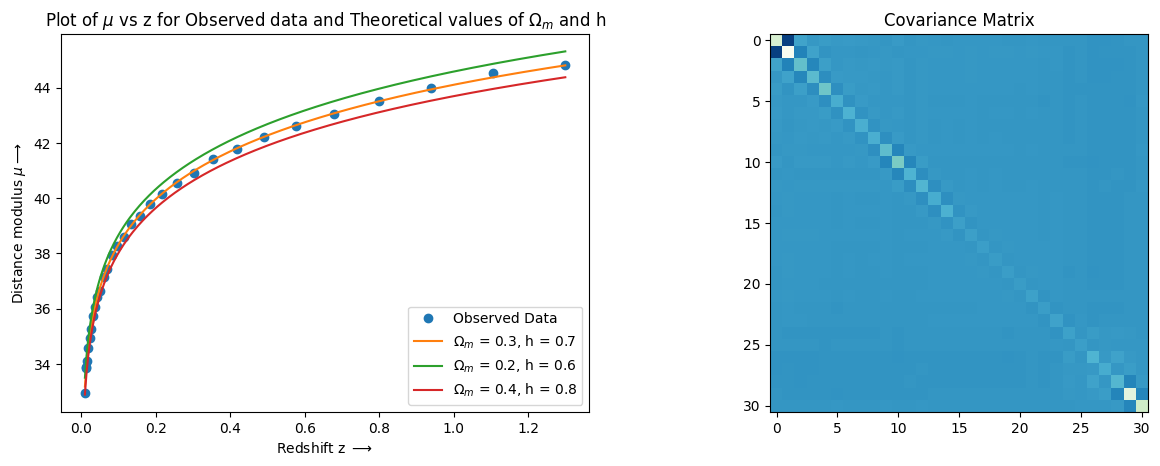

In [8]:
# Plot the data for 31 supernova
mu_th1 = mu_m(z_th, 0.3, 0.7)
mu_th2 = mu_m(z_th, 0.2, 0.6)
mu_th3 = mu_m(z_th, 0.4, 0.8)

fig = plt.figure()
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5), dpi = 100)

# Plot of z and mu for observed and theoretical data
ax1.plot(z, mu,'o', label = "Observed Data")
ax1.plot(z_th, mu_th1, label="$\Omega_m$ = 0.3, h = 0.7")
ax1.plot(z_th, mu_th2, label="$\Omega_m$ = 0.2, h = 0.6")
ax1.plot(z_th, mu_th3, label="$\Omega_m$ = 0.4, h = 0.8")
ax1.set_title('Plot of $\mu$ vs z for Observed data and Theoretical values of $\Omega_m$ and h')
ax1.set_xlabel('Redshift z $\longrightarrow$')
ax1.set_ylabel('Distance modulus $\mu \longrightarrow$')

# Plot of 31 x 31 covariance matrix
ax2.imshow(cov_matrix, cmap="GnBu_r")
ax2.set_title("Covariance Matrix")
ax1.legend()
plt.show()

**Importance sampling**

Consider a non-flat prior, so the target distribution is the posterior, not the likelihood. We can still sample from the likelihood (as you have been doing), and construct the posterior by weighting the points with the prior to get the target. This is an example of importance sampling, where we sample from a different distribution from the one we eventually want. Apply a prior on the Hubble constant to your chain, assuming a gaussian prior with mean $μ$ = 0.738 and standard deviation $\Omega_{m}$ = 0.024.

Now, plotting all the points in the chain will give a graph which looks the same as your previous graphs, so what should you do?

Compute the mean $h$, $\Omega_{m}$ with and without the prior.
Gaussian Prior with $h_m $ is:

\begin{equation}
    pdf = \frac{1}{\sqrt{2\pi\sigma^{2}}}exp{-\frac{{x-μ}^2}{2\sigma^2}}
\end{equation}

In [9]:
# Constrain the hubble parameter
mcmc_arr[0,1]= 0.738

# mcmc_arr[0,1]= np.random.normal(0.738, 0.024)
# Revising the assumed parameters with a gaussian distribution
sigma_Omega_m = 0.01
sigma_h = 0.024

# Calculate an initial likelyhood value and store it as the third column
mcmc_arr[0,2] = lnL(mcmc_arr[0,0], mcmc_arr[0,1])
accpt_nmbr = 0

# Draw new proposed samples from a proposal distribution, centered on old values Omega_m[i-1], h[i-1]
# Accept or reject, and colour points according to lnL(likelihood)
for i in range(1,nsamples):
    lnL_prev = mcmc_arr[i-1,npars]

# For Gaussian proposal distribution
    Omega_m_next = np.random.normal(mcmc_arr[i-1,0],sigma_Omega_m)
    h_next = np.random.normal(mcmc_arr[i-1,1],sigma_h)
    lnL_next = lnL(Omega_m_next,h_next)

# Define the Metropolis-Hastings algorithm to accept or reject the newly calculated point
# Accept the point if likelyhood has increased
    if(lnL_next > lnL_prev):
        mcmc_arr[i,0] = Omega_m_next
        mcmc_arr[i,1] = h_next
        mcmc_arr[i,npars] = lnL_next
        print("Accepted with a higher likelihood")
        accpt_nmbr += 1

    else:
        y = np.random.uniform()

# Otherwise, it is accepted with a lesser likelyhood defined by a threshold
# This is generated randomly everytime.
# To select a different threshold, select a value y = np.random.uniform() and then take log(y)
        if(lnL_next - lnL_prev > np.log(y)):
            mcmc_arr[i,0] = Omega_m_next
            mcmc_arr[i,1] = h_next
            mcmc_arr[i,npars] = lnL_next
            print("Accepted with a lesser likelihood")
            accpt_nmbr += 1

# Or, repeat the previous point in the chain to check if the draw is rejected. 
        else:
            mcmc_arr[i,0] = mcmc_arr[i-1,0]
            mcmc_arr[i,1] = mcmc_arr[i-1,1]
            mcmc_arr[i,2] = lnL_prev
            print("This draw is rejected")

# For value calculation, we reject the initial values given by the algorithm so as to only select the values, where the algorithm converges.
# Lets say we reject the initial 20% of the values.
reject = nsamples//20




print ('\n\n\nEstimated value of Omega_m = ' + str(np.mean(mcmc_arr[reject:nsamples,0])))
print ('Estimated value of h = ' + str(np.mean(mcmc_arr[reject:nsamples,1])))
print ('Estimated value of standard deviation of Omega_m = ' + str(np.std(mcmc_arr[reject:nsamples,0])))
print ('Estimated value of standard deviation of  h = ' + str(np.std(mcmc_arr[reject:nsamples,1])))
print ('Acceptance ratio is '+ str((accpt_nmbr*100)/nsamples)+"  percent")

Streaming output truncated to the last 5000 lines.
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
Accepted with a higher likelihood
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
Accepted with a higher likelihood
This draw is rejected
This draw is rejected
Accepted with a higher likelihood
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
Accepted with a higher likelihood
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
Accepted with a higher likelihood
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
This draw is rejected
Accepted with a higher likelihood
This draw is rejected
This draw is rejected
This draw is rejected
This draw is reject

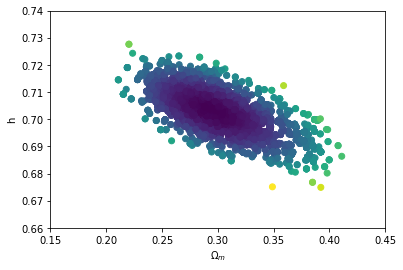

In [10]:
# Scatter Plot MCMC Omega_m and h distribution of the sample values
plt.scatter(mcmc_arr[reject:,0], mcmc_arr[reject:,1], c = -mcmc_arr[reject:,npars])
plt.xlim(0.15,0.45)
plt.ylim(0.66,0.74)
plt.xlabel(r'$\Omega_m$')
plt.ylabel('h')
plt.show()

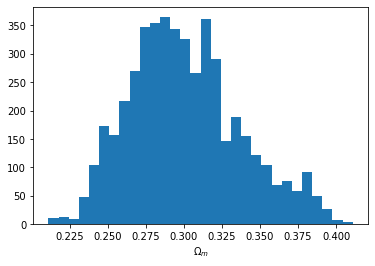

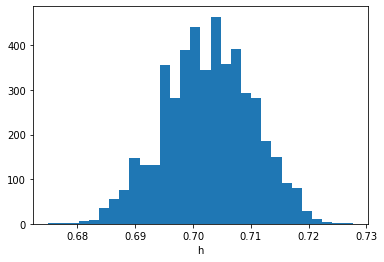

In [11]:
# Histogram of Omega_m
plt.hist(mcmc_arr[reject:,0], bins = 30)
plt.xlabel(r'$\Omega_m$')
plt.show()

# Histogram of h
plt.hist(mcmc_arr[reject:,1], bins = 30)
plt.xlabel('h')
plt.show()

**Gelman-Rubin Convergence Test**



In [12]:
### GELMAN-RUBIN MCMC Algorithm

# Revise (Gaussian) width of the proposal distribution
sigma_Omega = 0.01
sigma_h = 0.01

n_chains = 50
Omega_chain_mean = []
Omega_chain_var = []
h_chain_mean = []
h_chain_var = []

for chain in range(n_chains):
    print("Progress percentage:  " + str((chain*100)/n_chains))
    mcmc_arr = np.empty([nsamples,npars+1])

# Set initial likelyhood to a very low value so that next likelihood calculated is greater than that and is accepted
# Filling up the first row of the three columns
    mcmc_arr[0,0] = np.random.uniform()
    mcmc_arr[0,1] = np.random.uniform()

# Calculate an initial likelyhood value and store it as the third column
    mcmc_arr[0,2] = lnL(mcmc_arr[0,0], mcmc_arr[0,1])

    for i in range(1,nsamples):
        lnL_prev = mcmc_arr[i-1,2]
        Omega_m_next = np.random.normal(mcmc_arr[i-1,0],sigma_Omega)

# Sometimes Omega value jumps to larger than one due to random number generation
# Following is just a failsafe for that
        if (Omega_m_next > 0.99999999999):
            Omega_m_next = 0.99999999999
        else:
            pass
        h_next = np.random.normal(mcmc_arr[i-1,1],sigma_h)
        lnL_next = lnL(Omega_m_next,h_next)

# Now comes the Metropolis Hastings algorithm to accept or reject the newly calculated point
# Accept the point if likelyhood has increased
        if(lnL_next > lnL_prev):
            mcmc_arr[i,0] = Omega_m_next
            mcmc_arr[i,1] = h_next
            mcmc_arr[i,2] = lnL_next
            #print("Accepted with a higher likelihood")
        else:
            y = np.random.uniform()
            #if not, we accept it with a lesser likelyhood defined by a threshold
            if(lnL_next-lnL_prev>np.log(y)): # This can be randomized everytime to select a different threshold,
                                              # select a value y=np.random.uniform() and take log(y)
                mcmc_arr[i,0] = Omega_m_next
                mcmc_arr[i,1] = h_next
                mcmc_arr[i,2] = lnL_next
                #print("Accepted with a lesser likelihood")
            else:
                mcmc_arr[i,0] = mcmc_arr[i-1,0]
                mcmc_arr[i,1] = mcmc_arr[i-1,1]
                mcmc_arr[i,2] = lnL_prev
                #print("This draw is rejected")
        
# For value calculation, we reject the initial values given by the algorithm so as to only select the values where the algorithm converges(as taught in class)
# Lets say we reject the initial 20% of the values
    reject = nsamples//20
    mean_Omega_m = np.mean(mcmc_arr[reject:,0])
    mean_h = np.mean(mcmc_arr[reject:,1])
    var_Omega_m = np.var(mcmc_arr[reject:,0])
    var_h = np.var(mcmc_arr[reject:,1])
    Omega_chain_mean.append(mean_Omega_m)
    h_chain_mean.append(mean_h)
    Omega_chain_var.append(var_Omega_m)
    h_chain_var.append(var_h)


# Calculate formula values
Omega_sigma_chainsq = np.mean(Omega_chain_var)
Omega_sigma_meansq = np.var(Omega_chain_mean)

Ratio_Omega = ((((n_chains-1.0)/n_chains)*Omega_sigma_chainsq) + (Omega_sigma_meansq/n_chains))/(Omega_sigma_chainsq)

print("\n\n\nValue of the Gelman_Rubin Convergence Ratio for h using "+str(nsamples) + " MCMC samples is: " + str(Ratio_Omega))

h_sigma_chainsq = np.mean(h_chain_var)
h_sigma_meansq = np.var(h_chain_mean)

Ratio_h = ((((n_chains-1.0)/n_chains)*h_sigma_chainsq) + (h_sigma_meansq/n_chains))/(h_sigma_chainsq)

print("\nValue of the Gelman_Rubin Convergence Ratio for h using "+str(nsamples) + " MCMC samples is: " + str(Ratio_h))

Progress percentage:  0.0
Progress percentage:  2.0
Progress percentage:  4.0
Progress percentage:  6.0
Progress percentage:  8.0
Progress percentage:  10.0
Progress percentage:  12.0
Progress percentage:  14.0
Progress percentage:  16.0
Progress percentage:  18.0
Progress percentage:  20.0
Progress percentage:  22.0
Progress percentage:  24.0
Progress percentage:  26.0
Progress percentage:  28.0
Progress percentage:  30.0
Progress percentage:  32.0
Progress percentage:  34.0
Progress percentage:  36.0
Progress percentage:  38.0
Progress percentage:  40.0
Progress percentage:  42.0
Progress percentage:  44.0
Progress percentage:  46.0
Progress percentage:  48.0
Progress percentage:  50.0
Progress percentage:  52.0
Progress percentage:  54.0
Progress percentage:  56.0
Progress percentage:  58.0
Progress percentage:  60.0
Progress percentage:  62.0
Progress percentage:  64.0
Progress percentage:  66.0
Progress percentage:  68.0
Progress percentage:  70.0
Progress percentage:  72.0
Progre

In [15]:
# To define Convergence Test, Hamiltonian(Hybrid) Monte Carlo Algorithm is required


# Define some constants to be used throughout the code
HMC_sampls = 1000
leapfrog_sampls = 25
leapfrog_epsilon = 0.0006

# Below values are only for calculating the derivative of the Log Likelihood
sigma_Omega = 0.1
sigma_h = 0.1

# Exploratory MCMC function to calculate the derivatives dU/dx, it directly returns the gradient
def explore_MCMC(initial_Omega, initial_h):
    mcmc_sampl = 10
    mcmc_init = np.array([initial_Omega,initial_h])
    par = 2
    mcmc_arr = np.empty([mcmc_sampl,par+1])
    mcmc_arr[0,0] = mcmc_init[0]
    mcmc_arr[0,1] = mcmc_init[1]
    mcmc_arr[0,2] = lnL(mcmc_arr[0,0], mcmc_arr[0,1])
    i = 0
    for i in range(1,mcmc_sampl):
        lnl_prev = mcmc_arr[i-1,2]
        Omega_m_next = np.random.normal(mcmc_arr[i-1,0],sigma_Omega)

# Sometimes omega value jumps to larger than one due to random number generation
# Following is just a failsafe for that
        if(Omega_m_next > 0.99):
            Omega_m_next = 0.99
        else:
            pass
        h_next = np.random.normal(mcmc_arr[i-1,1],sigma_h)
        lnL_next = lnL(Omega_m_next,h_next)
        if(lnL_next > lnl_prev):
            mcmc_arr[i,0] = Omega_m_next
            mcmc_arr[i,1] = h_next
            mcmc_arr[i,2] = lnL_next
        else:
            y = np.random.uniform()
            if(lnL_next - lnl_prev > np.log(y)):
                mcmc_arr[i,0] = Omega_m_next
                mcmc_arr[i,1] = h_next
                mcmc_arr[i,2] = lnL_next
            else:
                mcmc_arr[i,0] = mcmc_arr[i-1,0]
                mcmc_arr[i,1] = mcmc_arr[i-1,1]
                mcmc_arr[i,2] = lnL_prev
        lnL_arr = mcmc_arr[:,2]

# Remember, U is negative of the log_likely, hence the gradient of U should also be multiplied by -1
        grad_val= -1 * mean(np.gradient(lnL_arr))
    return grad_val


'''
#hmc_array= np.empty((HMC_sampls,3))
#leapfrog_h_array= np.empty(leapfrog_sampls)
#leapfrog_omega_array= np.empty(leapfrog_sampls)'''

'\n#hmc_array= np.empty((HMC_sampls,3))\n#leapfrog_h_array= np.empty(leapfrog_sampls)\n#leapfrog_omega_array= np.empty(leapfrog_sampls)'

In [ ]:
### GELMAN-RUBIN HMC Algorithm

n_chains = 50
Omega_chain_mean = []
Omega_chain_var = []
h_chain_mean = []
h_chain_var = []


for chain in range(n_chains):

# Initial Guess for the parameters(The lists will be appended with every HMC step)
    Omega = [np.random.uniform(0.0,0.8)]         #omega_m
    h = [np.random.uniform(0.0,0.98)]            #h
    print("Progress percentage:  " + str((chain*100)/n_chains))

##### Main HMC loop
    
    for i in range(1,HMC_sampls):
        #print("percentage: "+ str((100*i)/HMC_sampls))
# we do bivariate gaussian sampling as we are sampling a 2D probability space
# Mu is the mean of the 2D gaussian
        Mu = [0.0,0.0]

# Covariance matrix for the 2D gaussian
        covmat = [[1.0,0.0],[0.0,1.0]]

# select the last updated value of Omega_m and h in their respective lists
        old_omega = Omega[len(Omega)-1]
        old_h = h[len(h)-1]

# Calculate old Potential Energy("U" in Haijan's paper)
        PE_old = -1*lnL(old_omega, old_h)

# Calculate the gradient for the first step of the leapfrog
        old_grad = explore_MCMC(old_omega, old_h)

# Shallow copy the last updated omega value from the omega array and h array to start the leapfrog
        new_omega = copy.copy(old_omega)
        new_h = copy.copy(old_h)
        new_grad = copy.copy(old_grad)
        #u= np.random.normal(0.0,1.0)

# Sampling from a 2D gaussian for two parameters
        v = np.random.multivariate_normal(Mu, covmat)  
        H_old = PE_old+ (np.dot(v,v))/2.0

# Leapfrog Method
        for j in range(leapfrog_sampls):
            v[0] = v[0]- (0.5*leapfrog_epsilon*new_grad)
            new_omega = new_omega + (leapfrog_epsilon*v[0])
            newgrad = explore_MCMC(new_omega, new_h)
            v[0] = v[0]- (0.5*leapfrog_epsilon*newgrad)
        
        for k in range(leapfrog_sampls):
            v[1] = v[1]- (0.5*leapfrog_epsilon*new_grad)
            new_h = new_h + (leapfrog_epsilon*v[1])
            newgrad = explore_MCMC(new_omega, new_h)
            v[1] = v[1]- (0.5*leapfrog_epsilon*newgrad)
        PE_new= -1*lnL(new_omega,new_h)
        #u= np.random.normal(0.0,1.0)
        v = np.random.multivariate_normal(Mu, covmat)
        H_new = PE_new + (np.dot(v,v))/2.0

# Accept reject in the similar Metropolis Hastings way
        dH = H_new - H_old
        if (dH<0.0):
            Omega.append(new_omega)
            h.append(new_h)
            #print("Accepted, yay!!"+ "  percentage complete: "+ str((100*i)/HMC_sampls))
        else:
            u_new = np.random.uniform(0.0,1.0)
            if(u_new<(np.exp(-1*dH))):
                Omega.append(new_omega)
                h.append(new_h)
                #print("Accepted, yay!!"+ "  percentage complete: "+ str((100*i)/HMC_sampls))
            else:
                Omega.append(old_omega)
                h.append(old_h)
                #print("Rejected, lol  "+ "  percentage complete: "+ str((100*i)/HMC_sampls))

# Lets say we reject the initial 20% of the values
    reject = HMC_sampls//80
    mean_omega_m = np.mean(Omega[reject:])
    mean_h = np.mean(h[reject:])
    var_omega_m = np.var(Omega[reject:])
    var_h = np.var(h[reject:])
    Omega_chain_mean.append(mean_omega_m)
    h_chain_mean.append(mean_h)
    Omega_chain_var.append(var_omega_m)
    h_chain_var.append(var_h)

# Calculate formula values
omega_sigma_chainsq = np.mean(Omega_chain_var)
omega_sigma_meansq = np.var(Omega_chain_mean)

Ratio_omega = ((((n_chains-1.0)/n_chains)*omega_sigma_chainsq) + (omega_sigma_meansq/n_chains))/(omega_sigma_chainsq)

print("\n\n\nValue of the Gelman_Rubin Convergence Ratio for Omega_m using "+str(HMC_sampls) + " HMC samples is: " + str(Ratio_omega))

h_sigma_chainsq = np.mean(h_chain_var)
h_sigma_meansq = np.var(h_chain_mean)

Ratio_h = ((((n_chains-1.0)/n_chains)*h_sigma_chainsq) + (h_sigma_meansq/n_chains))/(h_sigma_chainsq)

print("\nValue of the Gelman_Rubin Convergence Ratio for h using "+str(HMC_sampls) + " HMC samples is: " + str(Ratio_h))

Progress percentage:  0.0
Progress percentage:  2.0
Progress percentage:  4.0
Progress percentage:  6.0
Progress percentage:  8.0


Hamiltonian (Hybrid) Monte Carlo

In [ ]:
# Define some constants to be used throughout the code
HMC_samples = 5000
leapfrog_samples = 50
leapfrog_epsilon = 0.0006

# #Below values are only for calculating the derivative of the Log Likelihood
# sigma_omega = 0.1
# sigma_h = 0.1

# Exploratory MCMC function to calculate the derivatives dU/dx, it directly returns the gradient
def explore_MCMC(initial_Omega, initial_h):
    mcmc_sample = 5
    mcmc_init = np.array([initial_Omega,initial_h])
    par = 2
    mcmc_arr = np.empty([mcmc_sample, npars+1])
    mcmc_arr[0,0]= mcmc_init[0]
    mcmc_arr[0,1]= mcmc_init[1]
    mcmc_arr[0,2] = lnL(mcmc_arr[0,0], mcmc_arr[0,1])
    i=0
    for i in range(1,mcmc_sample):
        lnL_prev = mcmc_arr[i-1,2]
        Omega_m_next = np.random.normal(mcmc_arr[i-1,0], sigma_Omega_m)
        #Sometimes omega value jumps to larger than one due to random number generation
        #Following is just a failsafe for that
        if (Omega_m_next > 0.99):
            Omega_m_next = 0.99

        else:
            pass
        h_next = np.random.normal(mcmc_arr[i-1,1], sigma_h)
        lnL_next= lnL(Omega_m_next, h_next)
        if(lnL_next > lnL_prev):
            mcmc_arr[i,0] = Omega_m_next
            mcmc_arr[i,1] = h_next
            mcmc_arr[i,2] = lnL_next
        else:
            x = np.random.uniform()
            if(lnL_next - lnL_prev > np.log(x)):
                mcmc_arr[i,0] = Omega_m_next
                mcmc_arr[i,1] = h_next
                mcmc_arr[i,2] = lnL_next
            else:
                mcmc_arr[i,0] = mcmc_arr[i-1,0]
                mcmc_arr[i,1] = mcmc_arr[i-1,1]
                mcmc_arr[i,2] = lnL_prev
        lnL_arr = mcmc_arr[:,2]

# Remember, U is negative of the log_likely, hence the gradient of U should also be multiplied by -1
        grad_val = -1 * mean(np.gradient(lnL_arr))
    return grad_val

'''
# hmc_array = np.empty((HMC_samples,3))
# leapfrog_h_array = np.empty(leapfrog_samples)
# leapfrog_omega_array = np.empty(leapfrog_samples)
'''

#Initial Guess for the parameters(The lists will be appended with every HMC step)
Omega = [0.1]        #Omega_m
h = [0.1]            #h

In [ ]:
accpt_nmbr = 0

# Main HMC loop
for i in range(1, HMC_samples):

    # print("percentage: "+ str((100*i)/HMC_samples))
    # we do bivariate gaussian sampling as we are sampling a 2D probability space
    # Mu is the mean of the 2D gaussian
    Mu = [0.0,0.0]

# Covariance matrix for the 2D gaussian
    covmat = [[1.0,0.0], [0.0,1.0]]

# Select the last updated value of Omega_m and h in their respective lists
    old_Omega = Omega[len(Omega)-1]
    old_h = h[len(h)-1]

# Calculate old Potential Energy("U" in Haijan's paper)
    PE_old = -1*lnL(old_Omega, old_h)

# Calculate the gradient for the first step of the leapfrog
    old_grad = explore_MCMC(old_Omega, old_h)

# Shallow copy the last updated omega value from the omega array and h array to start the leapfrog
    new_Omega = copy.copy(old_Omega)
    new_h = copy.copy(old_h)
    new_grad = copy.copy(old_grad)
    #u = np.random.normal(0.0,1.0)

# Sampling from a 2D gaussian for two parameters
    v = np.random.multivariate_normal(Mu, covmat)  
    H_old = PE_old + (np.dot(v,v))/2.0

# Define Leapfrog method
    for j in range(leapfrog_samples):
        v[0] = v[0] - (0.5 * leapfrog_epsilon * new_grad)
        new_Omega = new_Omega + (leapfrog_epsilon * v[0])
        newgrad = explore_MCMC(new_Omega, new_h)
        v[0] = v[0] - (0.5 * leapfrog_epsilon * newgrad)
    for k in range(leapfrog_samples):
        v[1] = v[1] - (0.5 * leapfrog_epsilon * new_grad)
        new_h = new_h + (leapfrog_epsilon * v[1])
        newgrad = explore_MCMC(new_Omega, new_h)
        v[1] = v[1] - (0.5 * leapfrog_epsilon * newgrad)
    PE_new = -1 * lnL(new_Omega, new_h)
    #u = np.random.normal(0.0,1.0)
    v = np.random.multivariate_normal(Mu, covmat)
    H_new = PE_new + (np.dot(v,v))/2.0

# Accept reject in the similar Metropolis Hastings way
    dH = H_new - H_old
    if (dH < 0.0):
        Omega.append(new_Omega)
        h.append(new_h)
        accpt_nmbr += 1
        print("Accepted, yay!!"+ "  percentage complete: "+ str((100*i)/HMC_samples))
    else:
        u_new = np.random.uniform(0.0, 1.0)
        if(u_new < (np.exp(-1 * dH))):
            Omega.append(new_Omega)
            h.append(new_h)
            accpt_nmbr += 1
            print("Accepted, yay!!"+ "  percentage complete: "+ str((100*i)/HMC_samples))
        else:
            Omega.append(old_Omega)
            h.append(old_h)
            print("Rejected, lol  "+ "  percentage complete: "+ str((100*i)/HMC_samples))

reject= HMC_samples//25

print ('\n\n\nEstimated value of Omega_m = '+ str(np.mean(Omega[reject:])))
print ('Estimated value of h = '+ str(np.mean(h[reject:])))
print ('Estimated value of standard deviation of Omega_m = '+ str(np.std(Omega[reject:])))
print ('Estimated value of standard deviation of  h = '+ str(np.std(h[reject:])))
print ('Acceptance ratio is '+ str((accpt_nmbr*100)/HMC_samples)+" %")

In [ ]:
# To plot in realtime, just uncomment the following block(ONLY JUST THE FOLLOWING BLOCK)
# Keep in mind that the code runs slower if we plot in realtime, its just good to let it in the default settings
#(plotting after all calculations are done)

############################################################################################
plt.xlabel("Omega_m")
plt.ylabel('h')
plt.title("Samples Drawn using HMC Algorithm")
plt.xlim((0.0,1.0))
plt.ylim((0.0,1.0))
plt.scatter(Omega[:],h[:], c='blueviolet', alpha=0.2, marker='o', label="HMC", s=25)
# plt.pause(0.0005)
plt.show()
#############################################################################################



         
#To plot The post burn in samples of the run

##############################################################################################

ax1 = fig.add_subplot(121)
plt.xlabel("z")
plt.ylabel('mu')
plt.title("A comparison of Theoretical and Observed Values")
ax1.plot(z, mu, c='blue', marker='x', label="Observed Data")
ax2 = fig.add_subplot(122)
plt.xlabel("Omega_m")
plt.ylabel('h')
plt.title("Samples Drawn using HMC Algorithm")
plt.scatter(Omega[200:], h[200:], c='blueviolet', alpha=0.2, marker='o', label="HMC", s=25)
plt.xlim((0.1,0.5))
plt.ylim(0.6,0.8)
#plt.pause(0.0005)

#To plot the z vs mu function for out theoretical values
'''
y_theoretical = np.empty(snbins)
for i in range(snbins):
    y_theoretical[i] = mu_theory(z[i], np.mean(Omega[reject:]), np.mean(h[reject:]))
ax1.plot(z, y_theoretical, c='red', marker='+', label="Theoretical value from MCMC")
ax1.legend()
plt.title("The Parameter space of h and omega_m")
plt.show()
'''
##############################################################################################




# To Plot Histograms of h and Omega_m

###############################################################################################
'''
ax1 = fig.add_subplot(121)
plt.xlabel("Omega_m")
plt.ylabel("Counts")
ax1.hist(Omega[200:],bins=10)
ax2 = fig.add_subplot(122)
plt.xlabel("h")
plt.ylabel("Counts")
ax2.hist(h[200:],bins=10)
plt.show()
'''
###############################################################################################



#2D Histogram for both the values
###############################################################################################
'''
plt.hist2d(Omega[200:],h[200:], bins=(10,10))
plt.xlabel("Omega_m")
plt.ylabel('h')
plt.show()
'''
###############################################################################################